<a href="https://colab.research.google.com/github/monuminu/Vehicle_Style_Prediction/blob/main/Vehicle_Style_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!unzip /content/Data.zip

unzip:  cannot find or open /content/Data.zip, /content/Data.zip.zip or /content/Data.zip.ZIP.


In [8]:
# Importing desired modles
import pandas as pd
import numpy as np
from numpy import inf
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
import tensorflow.keras.layers as L
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import os
%matplotlib inline

In [9]:
# Reading all the three rawdata files 
rawdata = pd.read_csv("/content/Train.csv")
traveldata = pd.read_csv("/content/Train_Vehicletravellingdata.csv", index_col= None)
weatherdata = pd.read_csv("/content/Train_WeatherData.csv")

In [10]:
weatherdata = weatherdata.drop_duplicates().reset_index(drop = True)
rawdata = rawdata.drop_duplicates().reset_index(drop = True)
traveldata = traveldata.drop_duplicates().reset_index(drop = True)

In [11]:
weatherdata.columns = weatherdata.columns.str.replace(' ','_')
rawdata.columns = rawdata.columns.str.replace(' ','_')
traveldata.columns = traveldata.columns.str.replace(' ','_')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



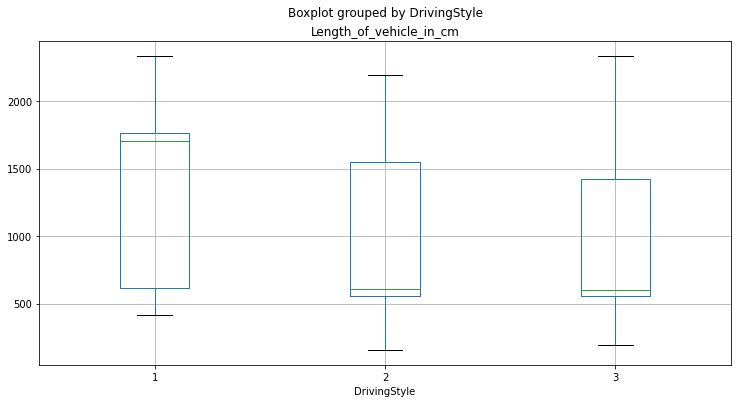

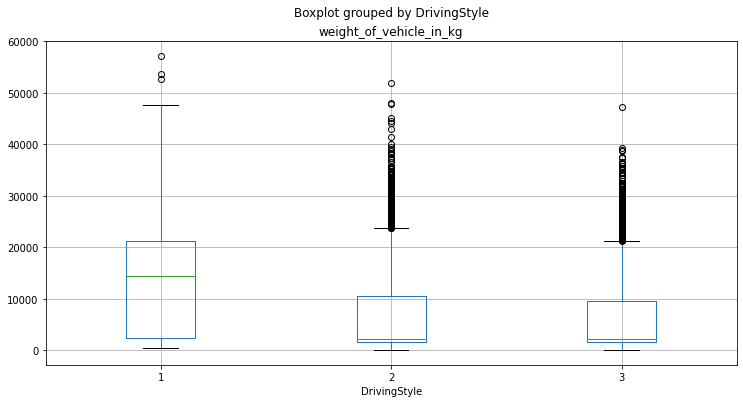

In [12]:
# Checking the distribution of vehicle length and weight across different driving styles. 
rawdata.boxplot(column =  ["Length_of_vehicle_in_cm"], by = "DrivingStyle", figsize=(12, 6))
rawdata.boxplot(column =  ["weight_of_vehicle_in_kg"], by = "DrivingStyle", figsize=(12, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74ab49d410>,
      dtype=object)

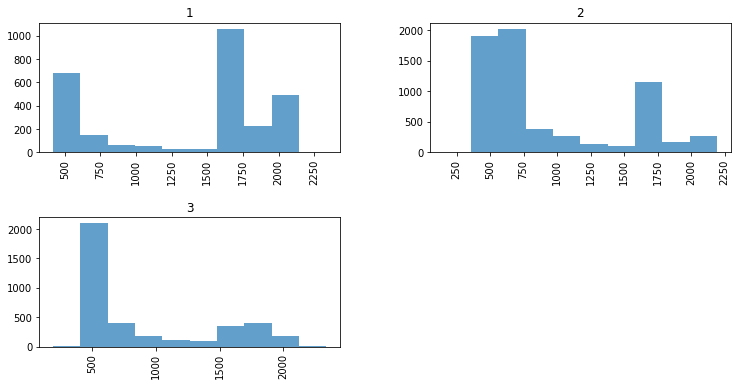

In [13]:
rawdata['Length_of_vehicle_in_cm'].hist(by=rawdata['DrivingStyle'], figsize=[12,6], alpha =.7)

In [14]:
cons_df = pd.concat([traveldata, weatherdata.drop(columns=['ID', 'Date_time'])], axis=1)
cons_df = cons_df.merge(rawdata, on=['ID'])
cons_df.head()

,ID,Date_time,Lane_of_the_road,Speed_of_the_vehicle_(kph),ID_of_the_preceding_vehicle,Speed_of_the_preceding_vehicle,Weight_of_the_preceding_vehicle,Length_of_preceding_vehicle,Time_gap_with_the_preceeding_vehicle_in_seconds,Road_Condition,Weather_details-Air_temperature,Precipitation,Precipitation_intensity,Relative_humidity,Wind_direction,Wind_speed_in_m/s,Day_time,Length_of_vehicle_in_cm,weight_of_vehicle_in_kg,Number_of_axles,DrivingStyle
0,DR_24526,21-03-2012 09:14,1,81,57227,87,16986,941,94.0,Dry,7.0,clear,None,95.0,146.0,1.0,daylight,1265,10243,2,2
1,DR_24526,21-03-2012 09:15,1,88,57229,81,1708,551,11.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight,1265,10243,2,2
2,DR_24526,21-03-2012 09:15,1,88,57230,88,22892,1698,4.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight,1265,10243,2,2
3,DR_24526,21-03-2012 09:15,2,84,57228,89,1945,544,127.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight,1265,10243,2,2
4,DR_24526,21-03-2012 09:15,1,89,57231,88,13787,1893,42.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight,1265,10243,2,2


In [15]:
# Let's see the count of target variable
driving_style_df = cons_df['DrivingStyle'].value_counts().to_frame()
driving_style_df.columns = ['count']
driving_style_df['Labels'] = driving_style_df.index
fig = px.bar(driving_style_df, x='Labels', y='count')
fig.show()

In [16]:
# Count of missing values in columns
missing_values = cons_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values()

missing_values = missing_values.to_frame()
missing_values.columns = ['count']
missing_values.index.names = ['Name']
missing_values['Name'] = missing_values.index

fig = px.bar(missing_values, x='Name', y='count')
fig.show()

In [17]:
cons_df[ ['Road_Condition', 'Precipitation', 'Precipitation_intensity', 'Day_time']] = cons_df[ ['Road_Condition', 'Precipitation', 'Precipitation_intensity', 'Day_time']].astype(str)

In [18]:
label_encoding_columns = ['Road_Condition', 'Precipitation', 'Precipitation_intensity', 'Day_time']
cons_df[label_encoding_columns] = cons_df[label_encoding_columns].apply(LabelEncoder().fit_transform)

In [19]:
train_df = cons_df.drop(columns=['ID_of_the_preceding_vehicle', 'Date_time', 'DrivingStyle'])

missing_values_columns = list(missing_values['Name'])

for col in missing_values_columns:
    train_df[col] = train_df[col].fillna(train_df[col].mean())

In [20]:
train_df = train_df.drop(train_df[(train_df['Speed_of_the_vehicle_(kph)'] >140) | (train_df['Speed_of_the_vehicle_(kph)']< 20)].index).reset_index(drop=True)    

# Speed Ratio
train_df['speed_ratio'] = (train_df['Speed_of_the_vehicle_(kph)']/train_df['Speed_of_the_preceding_vehicle']).clip(0, 2)

# Time ratio
train_df['time_ratio1'] = (train_df['Time_gap_with_the_preceeding_vehicle_in_seconds']/train_df['Speed_of_the_vehicle_(kph)']).clip(0, 2)
train_df['time_ratio2'] = (train_df['Time_gap_with_the_preceeding_vehicle_in_seconds']/train_df['Speed_of_the_preceding_vehicle']).clip(0, 2)

# Weight Ratio
train_df['weight_ratio'] = (train_df['Weight_of_the_preceding_vehicle']/train_df['weight_of_vehicle_in_kg']).clip(0, 100)

In [21]:
scaling_columns = [
    'Speed_of_the_vehicle_(kph)', 'Speed_of_the_preceding_vehicle', 'Length_of_preceding_vehicle',
    'Time_gap_with_the_preceeding_vehicle_in_seconds', 'Weather_details-Air_temperature', 'Weight_of_the_preceding_vehicle',
    'Relative_humidity', 'Wind_direction', 'Wind_speed_in_m/s', 'Length_of_vehicle_in_cm', 'weight_of_vehicle_in_kg',
    'Number_of_axles', 'Number_of_axles'
]
scaler = StandardScaler()
train_df[scaling_columns] = scaler.fit_transform(train_df[scaling_columns])

In [22]:
train_df.head()

,ID,Lane_of_the_road,Speed_of_the_vehicle_(kph),Speed_of_the_preceding_vehicle,Weight_of_the_preceding_vehicle,Length_of_preceding_vehicle,Time_gap_with_the_preceeding_vehicle_in_seconds,Road_Condition,Weather_details-Air_temperature,Precipitation,Precipitation_intensity,Relative_humidity,Wind_direction,Wind_speed_in_m/s,Day_time,Length_of_vehicle_in_cm,weight_of_vehicle_in_kg,Number_of_axles,speed_ratio,time_ratio1,time_ratio2,weight_ratio
0,DR_24526,1,-0.263373,0.377781,1.617558,0.311769,-0.064408,0,1.08182,0,4,2.702916,-0.600174,-1.577022,0,0.806835,0.529681,-0.577064,0.931034,1.160494,1.080460,1.658303
1,DR_24526,1,0.487570,-0.262598,-0.447259,-0.497497,-0.536434,0,1.08182,0,4,2.702916,-0.975367,-2.063512,0,0.806835,0.529681,-0.577064,1.086420,0.125000,0.135802,0.166748
2,DR_24526,1,0.487570,0.484511,2.415752,1.882574,-0.576243,0,1.08182,0,4,2.702916,-0.975367,-2.063512,0,0.806835,0.529681,-0.577064,1.000000,0.045455,0.045455,2.234892
3,DR_24526,2,0.058460,0.591241,-0.415228,-0.512022,0.123265,0,1.08182,0,4,2.702916,-0.975367,-2.063512,0,0.806835,0.529681,-0.577064,0.943820,1.511905,1.426966,0.189886
4,DR_24526,1,0.594848,0.484511,1.185214,2.287207,-0.360135,0,1.08182,0,4,2.702916,-0.975367,-2.063512,0,0.806835,0.529681,-0.577064,1.011364,0.471910,0.477273,1.345992


In [24]:
sequences = list()
for name, group in tqdm(train_df.groupby(['ID'])):
    sequences.append(group.drop(columns=['ID']).values)

100%|██████████| 12994/12994 [00:10<00:00, 1193.13it/s]


In [25]:
sequences[0]

array([[ 2.00000000e+00,  1.02395812e+00, -1.43662665e+00,
        -4.82803015e-01, -6.63499947e-01,  7.03345271e-01,
         0.00000000e+00, -3.55704927e-05,  1.00000000e+00,
         5.00000000e+00, -1.97453056e-05, -3.78786093e-05,
        -3.31438279e-05,  1.00000000e+00, -6.33157096e-01,
        -5.00825010e-01, -5.77064156e-01,  1.32857143e+00,
         2.00000000e+00,  2.00000000e+00,  7.12876172e-01],
       [ 2.00000000e+00, -1.01431674e+00,  1.01816060e+00,
        -3.91576973e-01, -4.10345070e-01, -5.42121101e-01,
         0.00000000e+00, -3.55704927e-05,  1.00000000e+00,
         5.00000000e+00, -1.97453056e-05, -3.78786093e-05,
        -3.31438279e-05,  1.00000000e+00, -6.33157096e-01,
        -5.00825010e-01, -5.77064156e-01,  7.95698925e-01,
         1.35135135e-01,  1.07526882e-01,  1.04588061e+00],
       [ 1.00000000e+00, -1.44342724e+00, -5.82787607e-01,
         1.20305424e+00,  1.97180082e+00,  8.34556156e-02,
         0.00000000e+00, -3.55704927e-05,  1.00000000e